In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
column_names = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 27)]
train_df = pd.read_csv('./dataset/train_FD001.txt', sep='\s+', header=None, names=column_names)
test_df = pd.read_csv('./dataset/test_FD001.txt', sep='\s+', header=None, names=column_names)
true_rul = pd.read_csv('./dataset/RUL_FD001.txt', header=None)
train_df = train_df.dropna(axis=1, how="all")
test_df = test_df.dropna(axis=1, how="all")

# RNG
rng = np.random.RandomState(42)

In [80]:
test_df.shape

(13096, 18)

In [81]:
test_df.head()

,engine_id,cycle,setting1,setting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130


In [66]:
test_df['engine_id'].nunique()

100

In [67]:
true_rul.shape

(100, 1)

In [68]:
columns_to_drop = ["setting3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19"]
train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)


In [69]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Separate the columns to normalize and the columns to skip
columns_to_skip = train_df.columns[:2]
columns_to_normalize = train_df.columns[2:]

# Normalize only the selected columns
normalized_data = scaler.fit_transform(train_df[columns_to_normalize])

# Combine the normalized and unnormalized columns
train_df_normalized = pd.DataFrame(train_df[columns_to_skip].values, columns=columns_to_skip)
train_df_normalized = pd.concat([train_df_normalized, pd.DataFrame(normalized_data, columns=columns_to_normalize)], axis=1)

test_normalized = scaler.transform(test_df[columns_to_normalize])
test_df_normalized = pd.DataFrame(train_df[columns_to_skip].values, columns=columns_to_skip)
test_df_normalized = pd.concat([test_df[columns_to_skip].reset_index(drop=True),
                                pd.DataFrame(test_normalized, columns=columns_to_normalize)], axis=1)


In [70]:
train_df_normalized.shape

(20631, 18)

In [71]:
train_df_normalized['RUL'] = train_df_normalized.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

In [72]:
train_df_normalized.head()

,engine_id,cycle,setting1,setting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,RUL
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187


In [73]:
X = train_df_normalized.drop(columns=['engine_id', 'cycle', 'RUL'])
y = train_df_normalized['RUL']

In [74]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [75]:
X_test = test_df_normalized.groupby('engine_id').last().drop(columns=['cycle']).reset_index(drop=True)
y_test = true_rul

In [76]:
y_pred = model.predict(X_test)

In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 25.593806249892133
Mean Squared Error: 1026.7372528473584


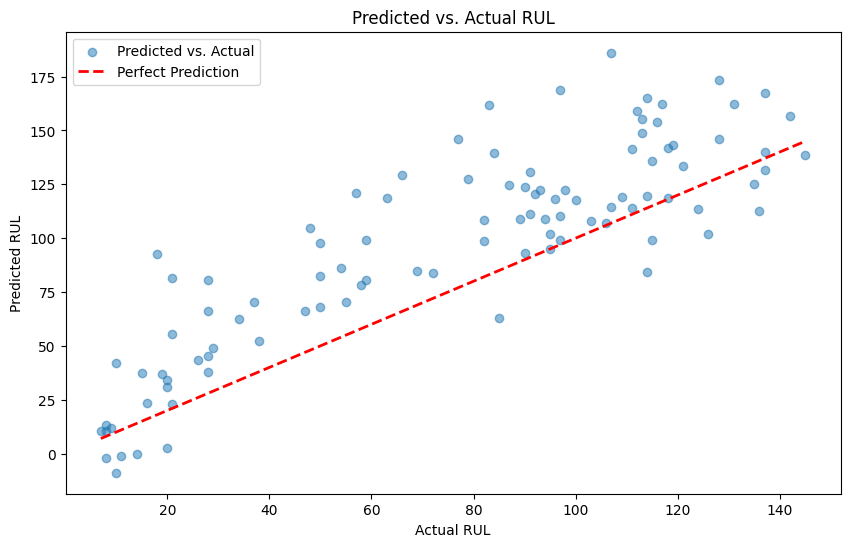

In [78]:
import matplotlib.pyplot as plt

# `y_test` contains the actual RUL values and `y_pred` contains the predicted RUL values

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted vs. Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction")
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Predicted vs. Actual RUL')
plt.legend()
plt.show()

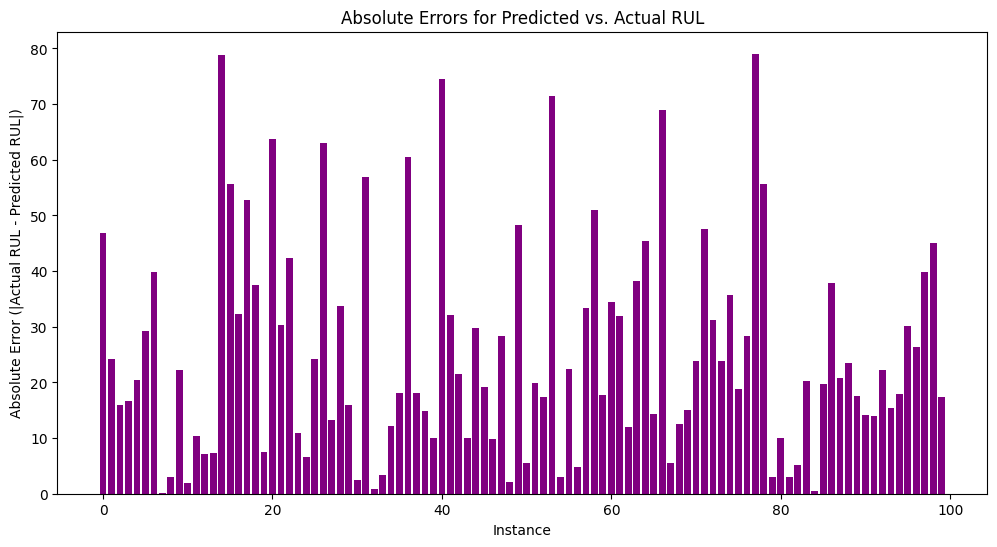

In [79]:
# Ensure y_test and y_pred are 1D arrays
y_test = np.array(y_test).flatten()
y_pred = np.array(y_pred).flatten()

# Calculate absolute errors
errors = np.abs(y_test - y_pred)

# Plot absolute errors as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(errors)), errors, color='purple')
plt.xlabel('Instance')
plt.ylabel('Absolute Error (|Actual RUL - Predicted RUL|)')
plt.title('Absolute Errors for Predicted vs. Actual RUL')
plt.show()